# OpenMC introduction

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [3]:
name='Jens'

In our previous endeavours we experienced that performing an accurate simulation of particle transport is not trivial. There are several softwares developed to solve this task, and for someone who is more interested in performing the analysis of a reactor core, it is often better to use an already verified and validated code instead of developing a new one from scratch. There are several such codes solving neutron transport either relying on deterministic or stochastic methods. During this datalab we will use a rather young code called OpenMC, which was originally developed at MIT.  

OpenMC is a Monte Carlo neutron and photon transport simulation code. It can be used both for fixed source and for criticality calculations. The user can define complicated geometries with constructive solid geometries. OpenMC is written in C++, however it has a rich Python API, which will allow us to comminicate with the code through jupyter notebooks.

OpenMC is not yet an industrial standard code, however our motivation to use it for this course was that it is 

1. freely available
2. the important physics we could not tackle within this course ourselves (eg. thermal scattering and several reactions) are implemented in it
3. since we can interact with the code through Python, we can deepen our programming skills
4. for small problems it runs relatively fast on a single PC

That said, today we are going to walk through a simple openMC input file. During this course we will only work with pincell models (ie. a single fuel pin infinite in the axial length with reflective boundaries, so neutrons are reflected back from the boundary in this way approximating an infinite core). This is of course a simplification of a complete reactor core, but it will still allow us to see a lot of cool physics. One could of course perform simulations at the assembly level or for a full-core, however such simulations would be more time consuming. There are several further examples at https://docs.openmc.org/.

**Note that this notebook should be opened from an environment where openmc is available!**

## The input file

During the datalab we will define the following problem which roughly matches a typical western-type pressurized water reactor's conditions:

- PWR pincell with reflective boundaries
- Fuel radius: 0.41 cm
- Fuel material: enriched UO2 with density 10.5 g/cm3
- Cladding inner/outer radius: 0.42/0.45 cm
- Cladding material: zirconium  with density 6.6 g/cm3
- Coolant/moderator: pressurized water with density 0.75 g/cm3
- Cell pitch: 1.26 cm

Note that in practice, PWR fuel cladding is made of an alloy called Zircaloy, nevertheless it has little influence on the neutron economy, therefore we will approximate it as pure zirconium with its natural abundance of isotopes.

So what do we need in order to define an openMC input?

1. Materials: which materials are included in our geometry (nuclide content, temperature, density)?
2. Geometry: how does the geometry look like? 
3. Tally: what are the quantities of interest? For example flux, or fission rate?
4. Settings: how many neutrons we would like to include in the calculation?

For each of these steps we will use the python API to export an xml file, which the code will use once we execute it. Note however that one could directly write xml files without using python, and run the code outside of Jupyter. For larger problems this is sometimes better. However we will want to analyse the output results in python, and sometimes we will script the input, so for us it is handy to use the python API.

Let's get started!

### Import

We will need first to import openmc, and of course anything else we might need.

In [4]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import os

path = '/root/jeff-3.3-hdf5/cross_sections.xml'

### Materials

Do you remember the example `Material()` class we developed before? That is pretty similar to the `Material()` class of openMC. We create an instance of `Material()`, with a numeric id of the material, and then we can add nuclides, and set the density. We can also set the temperature (which can be 294 K, 600 K, 900 K, 1200 K, 2500 K, the temperatures at which the available cross sections are evaluated). There are other options as well (for example one can directly set the enrichment), what you can find in the documentation.

If the nuclide inventory is not relevant for a material, we can add elements, in which case openMC will assume the natural abundance of isotopes.

Notice that for water we will need to link to the $S(\alpha,\beta)$ laws, since we need to take into account the molecular bounds for scattering on hydrogen. 

Finally, we create an instance of `Materials()` (note, it is plural now!), and link the materials of the problem to this object. Then with the `export_to_xml()` method we export the information into an xml file. 

In [5]:
uo2 = openmc.Material(1, "uo2",temperature=1200)
# Add nuclides to uo2
uo2.add_nuclide('U235', 0.04)
uo2.add_nuclide('U238', 0.96)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.5)


#cladding
zirconium = openmc.Material(2, "zirconium",temperature=900)
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

#coolant
water = openmc.Material(3, "h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 0.75)

water.add_s_alpha_beta('c_H_in_H2O')

#creating Materials() and exporting to xml
mats = openmc.Materials([uo2, zirconium, water])
mats.cross_sections = path
mats.export_to_xml()

We can print the content of the created xml file, with the linux command `cat`. (The `!` sign let's the python interpreter know that this is a command of the operating system.

You can see how all the information was structured in an xml (which is probably familiar from the previous datalab).  

In [6]:
#!cat materials.xml

### Geometry

Defining the geometry is only marginally more complicated. We will need to define surfaces (eg. `ZCylinder()`, `XPlane()`, and `YPlane()`), and regions bounded by the surfaces. Then we link the regions and the filling material to `Cell()` objects, which all have a numeric ID.  

Our geometry is infinite in the axial dimension. First we define three cylinders (the bounding surfaces of the fuel, and the cladding). Then we use constuctive solid geometry rules to define the regions between the surfaces, and create the fuel pin. Finally we will define the water region around the fuel.

We will then need to define a `Universe()` (the usefulness of this is not apparent in our simple exercise, but when defining reactor cores with repetitive patterns of various types of fuel assemblies, then "universes" are the way to handle this in most neutron transport code. You do not need to worry about this in this course). And finally we create a `Geometry()`, and link the universe. We will then export the information into an xml file. 

We further commented the lines to explain them

In [7]:
fuel_or = openmc.ZCylinder(r=0.41) #fuel cylinder with outer radius
clad_ir = openmc.ZCylinder(r=0.42) #clad inner cylinder with inner radius
clad_or = openmc.ZCylinder(r=0.45) #clad outer cylinder with outer radius


fuel_region = -fuel_or                #inside the fuel cylinder
gap_region = +fuel_or & -clad_ir      #outside of fuel cylinder and inside of clad inner cylinder
clad_region = +clad_ir & -clad_or     #outside of clad inner cylinder and inside of clad outer cylinder

fuel = openmc.Cell(1, 'fuel')
fuel.fill = uo2
fuel.region = fuel_region

#notice that for the gap between the fuel and the clad we do not need to link a material
# we consider that there is void there (considering the low density of the filling gas this is a fair approximation)
gap = openmc.Cell(2, 'air gap')
gap.region = gap_region

clad = openmc.Cell(3, 'clad')
clad.fill = zirconium
clad.region = clad_region


pitch = 1.26
#we define the x and y planes with boundary condition
left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

#outside of left and inside of right, outside of bottom, and inside of top and outside of clad outer cylinder
water_region = +left & -right & +bottom & -top & +clad_or

moderator = openmc.Cell(4, 'moderator')
moderator.fill = water
moderator.region = water_region

root = openmc.Universe(cells=[fuel, gap, clad, moderator])

geom = openmc.Geometry()
geom.root_universe = root
geom.export_to_xml()

We can again inspect the xml file.

In [8]:
#!cat geometry.xml

### Tally

We can describe the physical quantities of interest with tallies. If no tally is defined the code will only calculate the k-effective.

As we can see in the openMC documentation (in the user's guide) a tally is a quantity defined as

$\begin{equation}
X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int
dE}_{\text{filters}} \underbrace{f(\mathbf{r}, \mathbf{\Omega},
E)}_{\text{scores}} \psi (\mathbf{r}, \mathbf{\Omega}, E)
\end{equation}$

For example if function $f()$ would be unity, we would score the flux in a certain part of the phase space. If function $f()$ is a macroscopic cross section, we would score reaction rates.

Therefore we have to specify two things for a tally, which is created with a `Tally()` object:

1. *filters*: which part of the phase space we would like score at (for example only a certain part of the geometry is of interest, or certain energy bins)?
2. *scores*: what is the physical quantity of interest (for example flux, fission rate etc)

You can find a detailed description of the available scores and filters in the documentation.

Once the tallies are defined, we will need to link them into a `Tallies()` object, and export an xml file.

In the following code block we define three tallies.

1. tally for the neutron spectrum and the fission rate vs energy in the fuel
2. tally for the neutron spectrum in the moderator
3. a Mesh tally along the x-axis to tally the spatial dependence of the flux with three energy groups (thermal: 0-1eV, epithermal: 1eV-100keV, fast: 100keV-20MeV). Note, that we have to define 2 dimensions even if only 1 dimension is discretized spatially.

The reason why we tally the fission rate as well in the 1st tally is to see how openMC will store the results. 

In [9]:
# Tally 1: energy spectrum in fuel
cell_filter1 = openmc.CellFilter(fuel)
energybins=np.logspace(-2,7,1001) #1000 bins between 1e-2 eV and 1e7 eV
energy_filter = openmc.EnergyFilter(energybins)

t1 = openmc.Tally(1)
t1.filters = [cell_filter1,energy_filter]
t1.scores = ['flux','fission']

# Tally 2: energy spectrum in moderator
# we can use the same energy_filter as before
cell_filter2 = openmc.CellFilter(moderator)

t2 = openmc.Tally(2)
t2.filters = [cell_filter2,energy_filter]
t2.scores = ['flux']

# Tally 3: mesh tally in dimension x in three energy groups
energy_filter2 = openmc.EnergyFilter([0., 1, 100e3, 20.0e6])
myMesh=openmc.RegularMesh(name='xmesh')
myMesh.dimension=[100,1] #number of spatial bins along x axis and y axis
myMesh.lower_left=[-pitch/2,-pitch/2]
myMesh.upper_right=[pitch/2,pitch/2]
mesh_filter = openmc.MeshFilter(myMesh)

t3 = openmc.Tally(3)
t3.filters = [mesh_filter,energy_filter2]
t3.scores = ['flux']

tallies = openmc.Tallies([t1,t2,t3])
tallies.export_to_xml()

In [10]:
energybins

array([1.00000000e-02, 1.02093948e-02, 1.04231743e-02, ...,
       9.59400632e+06, 9.79489985e+06, 1.00000000e+07])

We can inspect the xml file.

In [11]:
#!cat tallies.xml

### Settings

There are some parameters we will need to set: we have to include the original source location and specify the number of batches and particles per batches for the criticality mode calculation. We also have to specify the number of "inactive" batches (these cycles are used to spread the fission source over the geometry, but the scores are still biased due to the original source not sampling all the possible fission sites properly). 

Since we have no better guess for the moment, we will place the source first in the center of the geometry. The number of batches and particles are set so that the results are reasonably accurate. If you wanted to have more accurate results you could increase these numbers, if you wanted to have shorter calculations, you could decrease these numbers.

Again, the instance of the `Setting()` object is exported to xml.

In [12]:
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 5000
settings.export_to_xml()

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [13]:
#!cat settings.xml

## Plotting the geometry

There are several ways of plotting the geometry. The simplest inline plotting option is to call the `plot()` method of the `Universe()` object (in our case this was called `root`). This is a wrapper of matplotlib. However, there is a more advanced options by setting up an instance of the `Plot()` class, and running openMC directly to generate a plot. Since in this course we work with a rather simple geometry, we will not look at the advanced plotting option, but you are welcome to check the user's guide.

In [14]:
#root.plot()
# Create a plot
plot = openmc.Plot(name='Fuelcell')
plot.type = 'slice'  # Plot type: 'slice' or 'voxel'
plot.basis = 'xy'  # 'xy', 'xz', or 'yz' slice
plot.origin = [0, 0, 0]  # Center of the plot
plot.width = [1.0, 1.0]  # Width of the plot in cm
plot.pixels = [400, 400]  # Resolution of the plot

# Add colors for materials
plot.colors = {fuel: 'red', clad: 'black', moderator: 'blue'}
# Export plot settings
plots = openmc.Plots([plot])
plots.export_to_xml()

# Run OpenMC in plotting mode
openmc.plot_geometry(output=False)

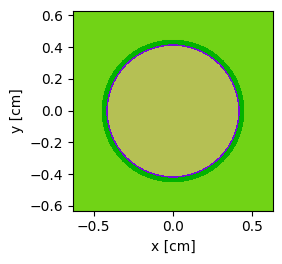

In [15]:
root.plot()
plt.show()

## Calculation

Finally, we are done, and nothing left just to run openMC and wait for the results. For this we have to specify where the cross section files are (this we could do in the system as well). Then call the `openmc.run()` method. And you immediately see how the k-effective is being estimated.

**Note 1**: The results are being stored in a file named 'statepoint.100.h5' (100 refers to the number of batches), also a 'summary.h5' and some other files are created. Sometimes openMC is complaining if there are already existing h5 files, so in this case we can remove (`rm`) these files. For this we make a system call with `os.system` to remove any file for which the name starts with 's' and ands with 'h5'. Nevertheless, be careful with removing files, not to loose data. 

**Note 2**: Sometimes the python API breaks for no apparent reason, you can just restart the kernel, if that happens. 

In [16]:
import os
os.system('rm s*h5')

openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Post-processing

Alright, we did our calculation, we even saw that some k-effective values were printed, but we still haven't seen any more results. For this we will need to read in the statepoint file. We will read this file into an object called `sp`. If we hit TAB while typing `sp.` we can review the available methods and attributes. For example we can get the final k-effective as below.

In [17]:
sp = openmc.StatePoint('statepoint.100.h5')
sp.keff

1.3927492921762694+/-0.0014907267827736367

In [18]:
?sp

Type:        StatePoint
String form: <openmc.statepoint.StatePoint object at 0x7feabe632ac0>
File:        /usr/local/lib/python3.9/dist-packages/openmc/statepoint.py
Docstring:  
State information on a simulation at a certain point in time (at the end
of a given batch). Statepoints can be used to analyze tally results as well
as restart a simulation.

Parameters
----------
filepath : str or Path
    Path to file to load
autolink : bool, optional
    Whether to automatically link in metadata from a summary.h5 file and
    stochastic volume calculation results from volume_*.h5 files. Defaults
    to True.

Attributes
----------
cmfd_on : bool
    Indicate whether CMFD is active
cmfd_balance : numpy.ndarray
    Residual neutron balance for each batch
cmfd_dominance
    Dominance ratio for each batch
cmfd_entropy : numpy.ndarray
    Shannon entropy of CMFD fission source for each batch
cmfd_indices : numpy.ndarray
    Number of CMFD mesh cells and energy groups. The first three indices
   

And the values we can access for further processing or plotting:

In [19]:
keff=sp.keff.nominal_value
keff_error=sp.keff.std_dev
print(keff,keff_error)

1.3927492921762694 0.0014907267827736367


The tallies are stored in a dictionary where the keys are the numeric IDs we defined previously:

In [20]:
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux', 'fission']
 	Estimator      =	tracklength
 	Multiply dens. =	True,
 2: Tally
 	ID             =	2
 	Name           =	
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength
 	Multiply dens. =	True,
 3: Tally
 	ID             =	3
 	Name           =	
 	Filters        =	MeshFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength
 	Multiply dens. =	True}

We can convert the tally results into pandas dataframes. So at the end we have a nice table, for each energy bin there is a row for the flux and a row for the fission rate. If we prefer we can split the dataframe based on conditions to store separately the flux and the fission rate. For this we can apply conditions as we have seen during the previous datalabs.

The results are stored in the 'mean' column.

In [21]:
tallydf1=sp.tallies[1].get_pandas_dataframe()
tallydf1.head() #prints the first 5 rows

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,1,0.010000,0.010209,total,flux,0.001003,0.000037
1,1,0.010000,0.010209,total,fission,0.000888,0.000033
2,1,0.010209,0.010423,total,flux,0.001012,0.000044
3,1,0.010209,0.010423,total,fission,0.000887,0.000039
4,1,0.010423,0.010641,total,flux,0.001090,0.000040


In [22]:
tallydf1flux=tallydf1[tallydf1['score']=='flux']
tallydf1fiss=tallydf1[tallydf1['score']=='fission']
tallydf1flux.head()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,1,0.010000,0.010209,total,flux,0.001003,0.000037
2,1,0.010209,0.010423,total,flux,0.001012,0.000044
4,1,0.010423,0.010641,total,flux,0.001090,0.000040
6,1,0.010641,0.010864,total,flux,0.001101,0.000042
8,1,0.010864,0.011092,total,flux,0.001115,0.000040


Let's plot these results.

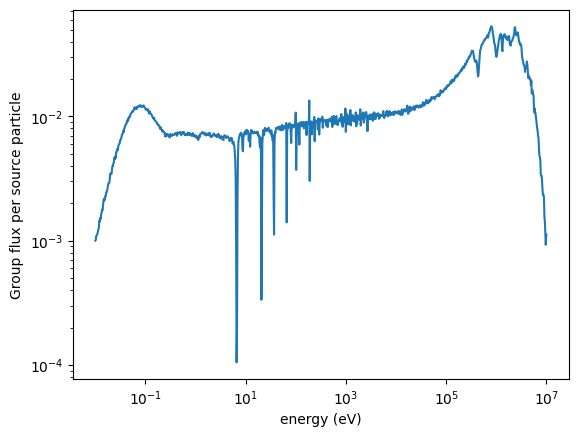

In [23]:
energy=(tallydf1flux['energy low [eV]']+tallydf1flux['energy high [eV]'])/2
plt.figure()
plt.loglog(energy, tallydf1flux['mean'])
plt.xlabel('energy (eV)')
plt.ylabel('Group flux per source particle')
plt.show()

These of course does not look like the spectrum we saw during the lecture. But here actually each value is not the flux at a certain energy, but the integral of the flux between energies. If we divide the integral flux with the width of the bins (`deltaE`) we get the more familiar shape for the spectrum.

We can clearly see the Maxwellien thermal component, the 1/E part with the self-shielding effect of the resonances, and the Watt-spectrum at high energies.

The very first "negative" peak is due to the 6.67 eV resonance of U-238.

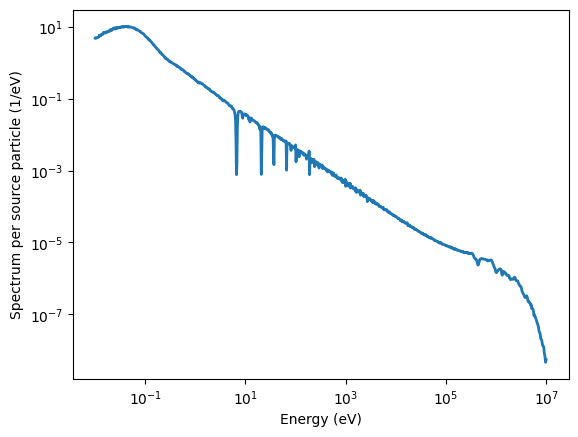

In [24]:
deltaE=(tallydf1flux['energy high [eV]']-tallydf1flux['energy low [eV]'])
plt.figure()
plt.loglog(energy,tallydf1flux['mean']/deltaE,lw=2)

plt.ylabel('Spectrum per source particle (1/eV)')
plt.xlabel('Energy (eV)')
plt.show()

In [59]:
tally2 = sp.tallies[2].get_pandas_dataframe()
tally2.head()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,4,0.010000,0.010209,total,flux,0.002865,0.000053
1,4,0.010209,0.010423,total,flux,0.003048,0.000058
2,4,0.010423,0.010641,total,flux,0.003082,0.000056
3,4,0.010641,0.010864,total,flux,0.003094,0.000058
4,4,0.010864,0.011092,total,flux,0.003227,0.000061


Now it is your turn to plot the spectrum in the moderator (preferably include both the fuel and the moderator spectrum in the same figure). You will need to `get_pandas_dataframe` from tally 2, and then plot the results. Compare with the spectrum in the fuel, what is the most noticable difference?

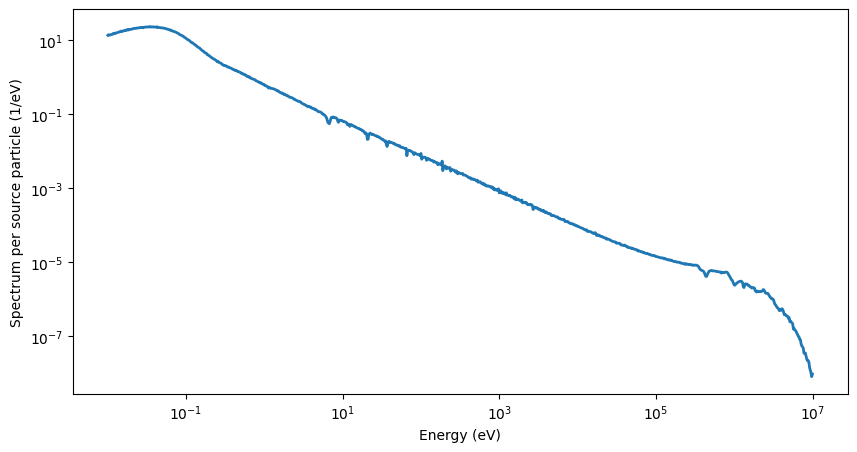

In [61]:
tally2flux = tally2[tally2['score']=='flux']
energy=(tally2flux['energy low [eV]']+tally2flux['energy high [eV]'])/2

deltaE=(tally2flux['energy high [eV]']-tally2flux['energy low [eV]'])

plt.figure(figsize=(10,5))
plt.loglog(energy,tally2flux['mean']/deltaE,lw=2)
plt.ylabel('Spectrum per source particle (1/eV)')
plt.xlabel('Energy (eV)')
plt.show()

In [67]:
tally3 = sp.tallies[3].get_pandas_dataframe()
tally3.head()

mesh 1       energy low [eV] energy high [eV] nuclide score      mean  \
       x  y  z                                                            
0      1  1  1             0.0              1.0   total  flux  0.058810   
1      1  1  1             1.0         100000.0   total  flux  0.157620   
2      1  1  1        100000.0       20000000.0   total  flux  0.182287   
3      2  1  1             0.0              1.0   total  flux  0.058701   
4      2  1  1             1.0         100000.0   total  flux  0.157448   

  std. dev.  
             
0  0.000155  
1  0.000215  
2  0.000294  
3  0.000157  
4  0.000196

Your conclusion comes here.

Finally, we can look at the spatial dependence of the flux. We read in the 3rd tally. Try to split the dataset according to the energy groups and plot the flux vs x-coordinate for the three energy groups separately. Normalize each curve by their maximum, so they are comparable.

Conclude your findings!

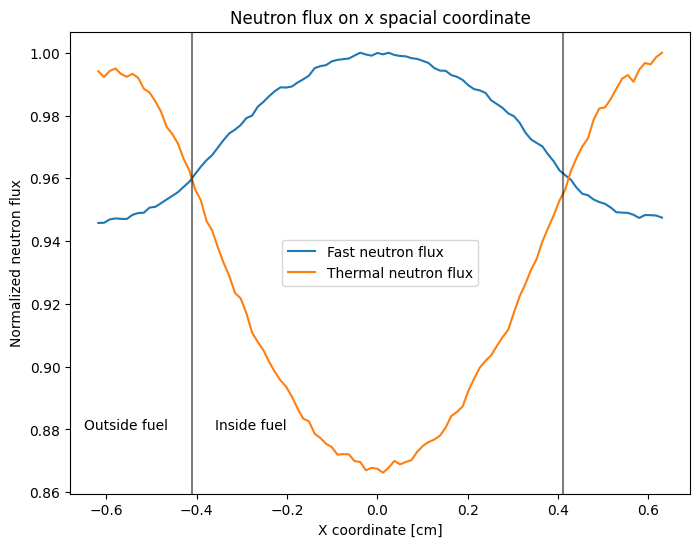

In [106]:
# fast neutrons
tally_fast = tally3.loc[tally3["energy low [eV]"] == 100000.0] # extract fast neutrons
mesh_fast = tally_fast[('mesh 1')]
xs_fast = mesh_fast['x']  * pitch/100 - pitch/2 # center x values in middle of cell
fast_mean = tally_fast['mean']

# thermal neutrons
tally_thermal = tally3.loc[tally3["energy low [eV]"] == 0.0] # extract thermal neutrons
mesh_thermal = tally_thermal[('mesh 1')]
xs_thermal = mesh_thermal['x']  * pitch/100 - pitch/2 # center x values in middle of cell
thermal_mean = tally_thermal['mean']

# plot
plt.figure(figsize=(8,6))

plt.plot(xs_fast,fast_mean/max(fast_mean), label='Fast neutron flux')
plt.plot(xs_thermal,thermal_mean/max(thermal_mean), label='Thermal neutron flux')

r=0.41 # radius of fuel
plt.axvline(r,color='black',alpha=0.5)
plt.axvline(-r,color='black',alpha=0.5)
plt.annotate('Inside fuel', xy=[-r+0.05,0.88])
plt.annotate('Outside fuel', xy=[-r-0.24,0.88])

plt.legend()
plt.title('Neutron flux on x spacial coordinate')
plt.xlabel('X coordinate [cm]')
plt.ylabel('Normalized neutron flux')
plt.show()

There are more thermal neutrons inside the fuel and more thermal neutrons in the moderator!

## Experiment time!

If time permits, modify your input, and see how the results change. Points of interest:

- Change the void content (ie. decrease the moderator density), and observe how the k-eff changes. What happens with the spectrum?
- What is the impact on the k-eff if you change the UO2 temperature?
- What is the impact of increasing the pitch of the pincell?

You can also take a look at the third set of home assignments, where you will need to implement various geometries in openMC, and already give it a try.